# <center> COVID-19 Spread Visualisation </center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
import networkx as nx
from ipywidgets import interactive

import imageio
from io import BytesIO
from typing import Dict, List, Any
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_data(name: str) -> Dict[str, Any]:
    result = {"cumulative_cities":[], "daily_cities":[], "total_infected":[]}
    for simulation in range(10):
        with open(f"{name}_{simulation}", 'rb') as f:
            data = pickle.load(f)

        data = pd.DataFrame(data).T
        daily_cities = data.groupby('day')['infected'].count()
        cumulative_cities = np.cumsum(daily_cities)
        total_infected = data['infected'].apply(np.max).sum()

        result["cumulative_cities"].append(cumulative_cities)
        result["daily_cities"].append(daily_cities)
        result["total_infected"].append(total_infected)  
    return result

def plot_with_std(data: pd.DataFrame, label: str, color: str):
    average = data.mean().sort_index()
    std = data.std().sort_index()
    plt.plot(average, label=label, color=color, linewidth=2)
    plt.fill_between(range(len(average)), average+std, average, alpha=0.1, color=color)
    plt.fill_between(range(len(average)), average-std, average, alpha=0.1, color=color)

In [3]:
realistic = read_data("../simulation_data/INFECTED_CITIES_realistic")
strict = read_data("../simulation_data/INFECTED_CITIES_strict")
mild = read_data("../simulation_data/INFECTED_CITIES_mild")

In [4]:
airport_df = pd.read_csv("../data/airport_df_preprocessed.csv", index_col=0)

In [5]:
realistic_label = 'Realistic quarantines after 30 days, 14 days to enforce'
strict_label = 'Strict quarantines after 14 days, 7 days to enforce'
mild_label = 'Mild quarantines after 60 days, 30 days to enforce'

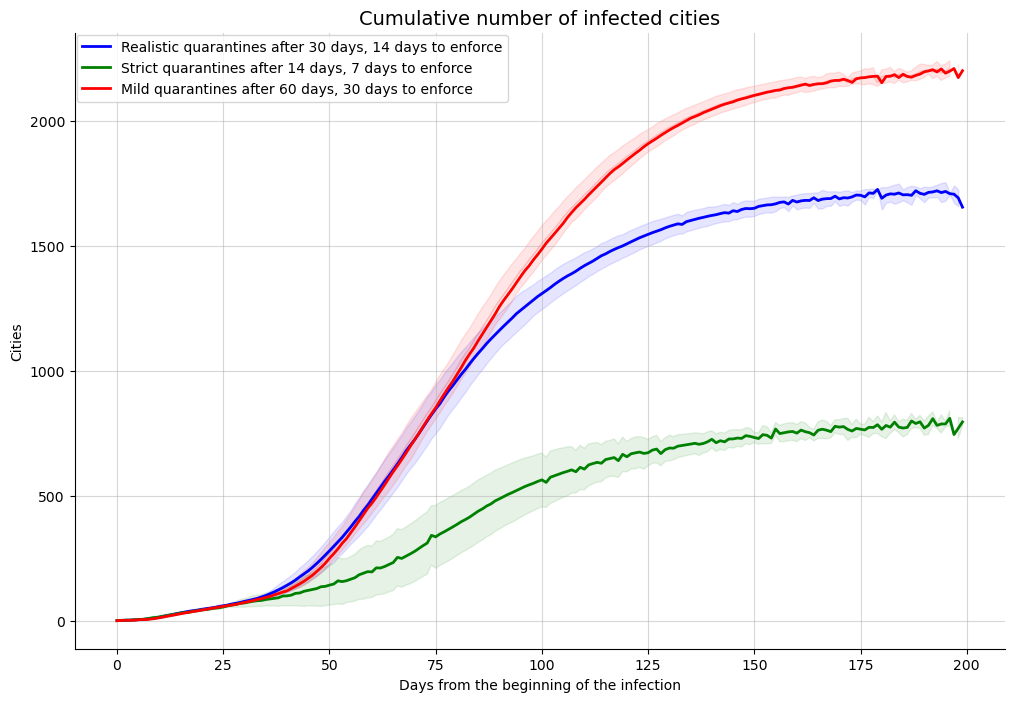

In [6]:
plt.figure(figsize=(12, 8))

for data, label, color in zip(
    [realistic, strict, mild], 
    [realistic_label, strict_label, mild_label],
    ['blue', 'green', 'red']
):
    plot_with_std(pd.DataFrame(data['cumulative_cities']), 
              label=label,
              color=color
             )
    
plt.title("Cumulative number of infected cities", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days from the beginning of the infection")
plt.grid(alpha=0.5)
plt.legend(loc=(0.002,0.888))
sns.despine()
plt.show()

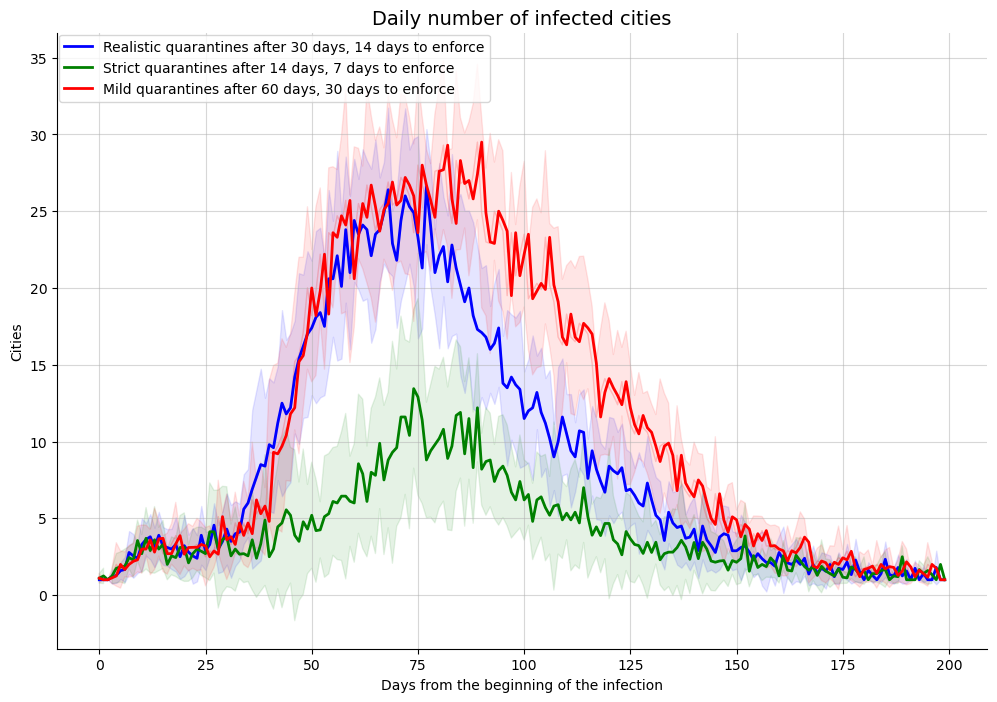

In [7]:
plt.figure(figsize=(12, 8))

for data, label, color in zip(
    [realistic, strict, mild], 
    [realistic_label, strict_label, mild_label],
    ['blue', 'green', 'red']
):
    plot_with_std(pd.DataFrame(data['daily_cities']), 
              label=label,
              color=color
             )
    
plt.title("Daily number of infected cities", fontsize=14)
plt.ylabel("Cities")
plt.xlabel("Days from the beginning of the infection")
plt.grid(alpha=0.5)
plt.legend(loc=(0.002,0.888))
sns.despine()
plt.show()

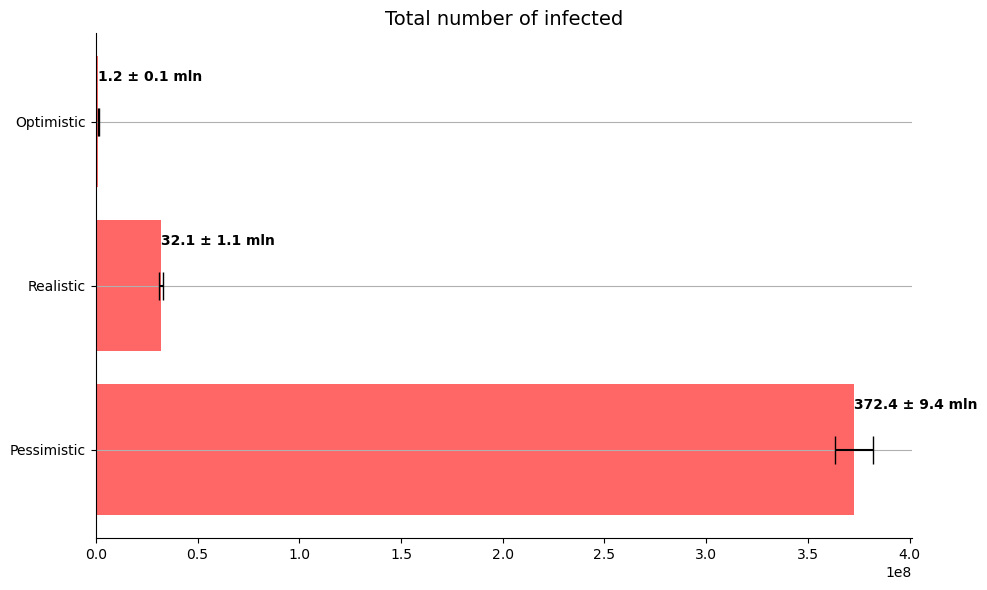

In [8]:
scenarios = ['Pessimistic', 'Realistic', 'Optimistic']
x_pos = np.arange(len(scenarios))

averages = [
    np.mean(mild['total_infected']),
    np.mean(realistic['total_infected']),
    np.mean(strict['total_infected']),
]

stds = [
    np.std(mild['total_infected'])*1.96,
    np.std(realistic['total_infected'])*1.96,
    np.std(strict['total_infected'])*1.96,
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(x_pos, averages, align='center', color='red', xerr=stds, alpha=0.6, ecolor='black', capsize=10)
ax.set_yticks(x_pos)
ax.set_yticklabels(scenarios)
ax.set_title('Total number of infected', fontdict={'size': 14})
ax.yaxis.grid(True)


for i, v in enumerate(averages):
    av = round(v/1000000, 1)
    std = round(stds[i]/1000000, 1)
    ax.text(v, i + .25, f"{av} ± {std} mln", color='black', fontweight='bold')

plt.tight_layout()
sns.despine()
plt.show()

In [9]:
np.array(averages)/airport_df.city_population.sum()

array([0.07685387, 0.00662254, 0.00025789])

In [10]:
def get_spread_data(file_name: str, airport_df: pd.DataFrame=airport_df):
    with open(file_name, 'rb') as f:
        spread_data = pickle.load(f)
        
    spread_data = pd.DataFrame(spread_data).T
    spread_data = spread_data[['from', 'day']].reset_index()
    spread_data.columns = ['destination', 'source', 'day']
    spread_data = spread_data[['source', 'destination', 'day']]
    
    spread_data = pd.merge(
        spread_data, airport_df[['City', 'Lat', 'Long']], left_on='source', right_on='City')

    spread_data = pd.merge(
        spread_data, airport_df[['City', 'Lat', 'Long']], left_on='destination', right_on='City')

    spread_data.drop(['City_x', 'City_y'], axis=1, inplace=True)
    spread_data.rename(columns={
        'Lat_x':'lat_source', 
        'Long_x':'long_source',
        'Lat_y':'lat_dest',
        'Long_y':'long_dest'
    }, inplace=True)
    
    return spread_data

def get_graph(result_cities: pd.DataFrame, airport_df=airport_df):
    graph = nx.from_pandas_edgelist(
        result_cities, 
        source = 'source', 
        target = 'destination',
        create_using = nx.DiGraph()
    )

    xycoords = {}

    for node in tqdm_notebook(list(graph.nodes), leave=False):
        xycoords[str(node)] = (
            airport_df.Long[airport_df.City ==node].values[0], 
            airport_df.Lat[airport_df.City == node].values[0]
        )
    return graph, xycoords

In [11]:
def visualise_spread_for_day(xycoords, day: int, chart_type: str, result_cities: pd.DataFrame):
    fig = plt.figure(figsize=(30, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    ax.add_feature(cfeature.LAND, color='#3d3d3d')
    ax.add_feature(cfeature.OCEAN, color='#04031c')
    ax.add_feature(cfeature.BORDERS)

    subgraph = nx.from_pandas_edgelist(
        result_cities[result_cities.day <= day], 
        source='source', 
        target='destination', 
        create_using=nx.DiGraph()
    )
    
    nx.draw_networkx_nodes(subgraph, pos=xycoords, node_color='r', node_size=10, alpha=1)
    plt.xlim(-180, 180)
    plt.ylim(-60, 80)
    
    if chart_type == "Nodes":
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)

        img_array = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        img_array = plt.imread(buf)  
        img_array = (img_array * 255).astype(np.uint8)
        plt.close()  
        return img_array

    geod = Geodesic()
    npts = 100

    # handling longitudes wrapping
    for edge in subgraph.edges():
        source, dest = edge
        source_coords = xycoords[source]
        dest_coords = xycoords[dest]

        # calculate the difference in longitudes
        lon_diff = abs(source_coords[0] - dest_coords[0])

        # if the difference is large, split into two segments to avoid crossing the edge of the map
        if lon_diff > 180:
            # this can happen if one point is on the far east (positive longitude)
            # and the other is on the far west (negative longitude).
            if source_coords[0] > 0:
                # source is in the east, dest in the west
                intermediate_lon = -180
            else:
                # source is in the west, dest in the east
                intermediate_lon = 180

            # Break the line into two parts
            geodesic_points_1 = geod.geod.npts(
                source_coords[0], source_coords[1], intermediate_lon, dest_coords[1], npts // 2)
            geodesic_points_2 = geod.geod.npts(
                intermediate_lon, dest_coords[1], dest_coords[0], dest_coords[1], npts // 2)

            lons1, lats1 = zip(*geodesic_points_1)
            lons2, lats2 = zip(*geodesic_points_2)

            ax.plot(lons1, lats1, color='orange', linestyle='solid', linewidth=1, alpha=0.7)
            ax.plot(lons2, lats2, color='orange', linestyle='solid', linewidth=1, alpha=0.7)

        else:
            geodesic_points = geod.geod.npts(
                source_coords[0], source_coords[1], dest_coords[0], dest_coords[1], npts)
            lons, lats = zip(*geodesic_points)
            ax.plot(lons, lats, color='orange', linestyle='solid', linewidth=1, alpha=0.7)

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)

    img_array = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    img_array = plt.imread(buf)  
    img_array = (img_array * 255).astype(np.uint8)
    plt.close()  
    return img_array


def create_gif(
    result_cities: pd.DataFrame, xycoords: dict, 
    filename: str, days: List[int], chart_type: str, fps: int=10
):
    frames = []
    
    for day in tqdm_notebook(days, desc="Creating GIF frames", leave=False):
        frame = visualise_spread_for_day(xycoords, day, chart_type, result_cities)
        frames.append(frame)  
    # repeat last frame a few times to make a "pause" at the end of the gif
    frames.extend([frame]*fps*3)
    imageio.mimsave(filename, frames, fps=fps) 

## Creating GIFs (obviously pronounced as "gif") for every scenario

In [12]:
for scenario in ['realistic', 'mild', 'strict']:
    result_cities = get_spread_data(f"../simulation_data/INFECTED_CITIES_{scenario}_0", airport_df)
    graph, xycoords = get_graph(result_cities, airport_df)
    
    for chart_type in ['Paths', 'Nodes']:
        create_gif(
            result_cities, xycoords, f"infection_spread_{scenario}_{chart_type.lower()}.gif", 
            days=list(range(0, 100)), chart_type=chart_type
        )

## Final states for every scenario

  0%|          | 0/1729 [00:00<?, ?it/s]

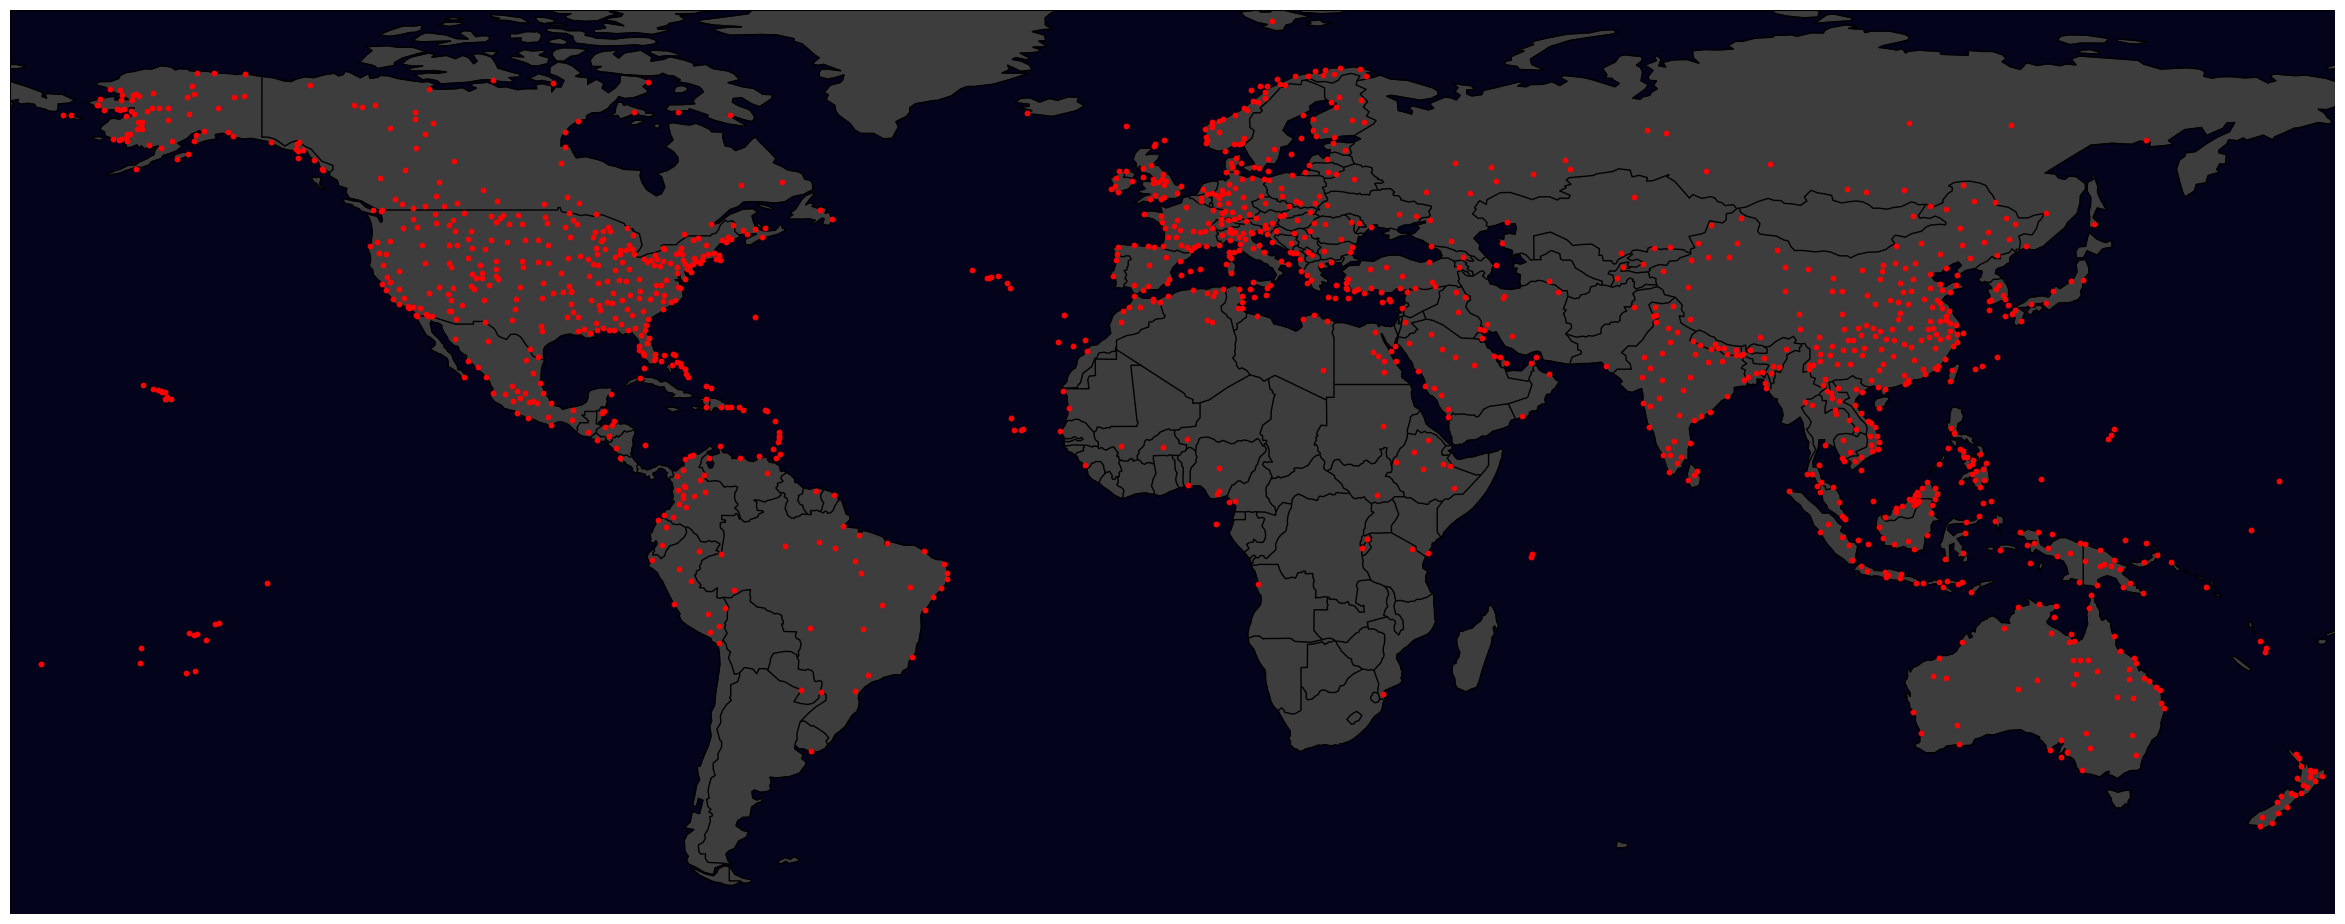

  0%|          | 0/2232 [00:00<?, ?it/s]

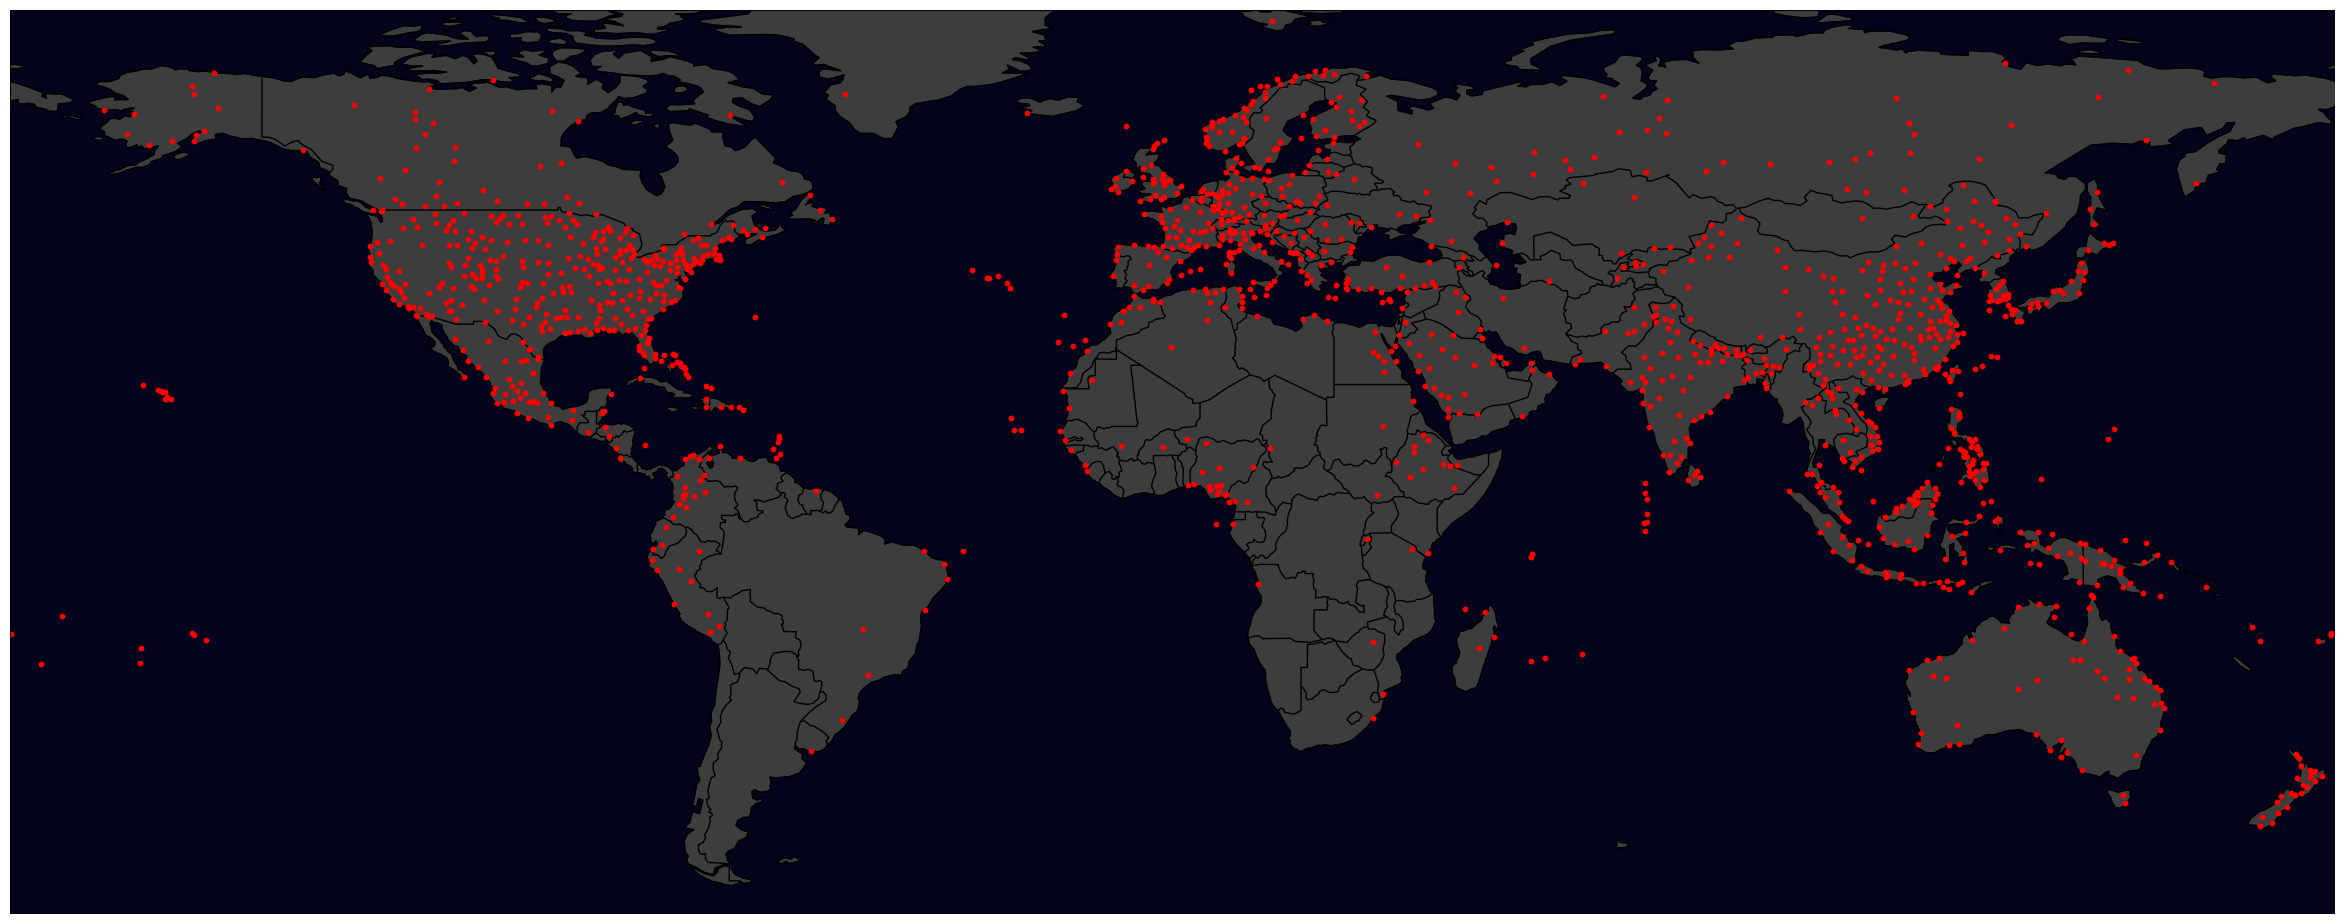

  0%|          | 0/745 [00:00<?, ?it/s]

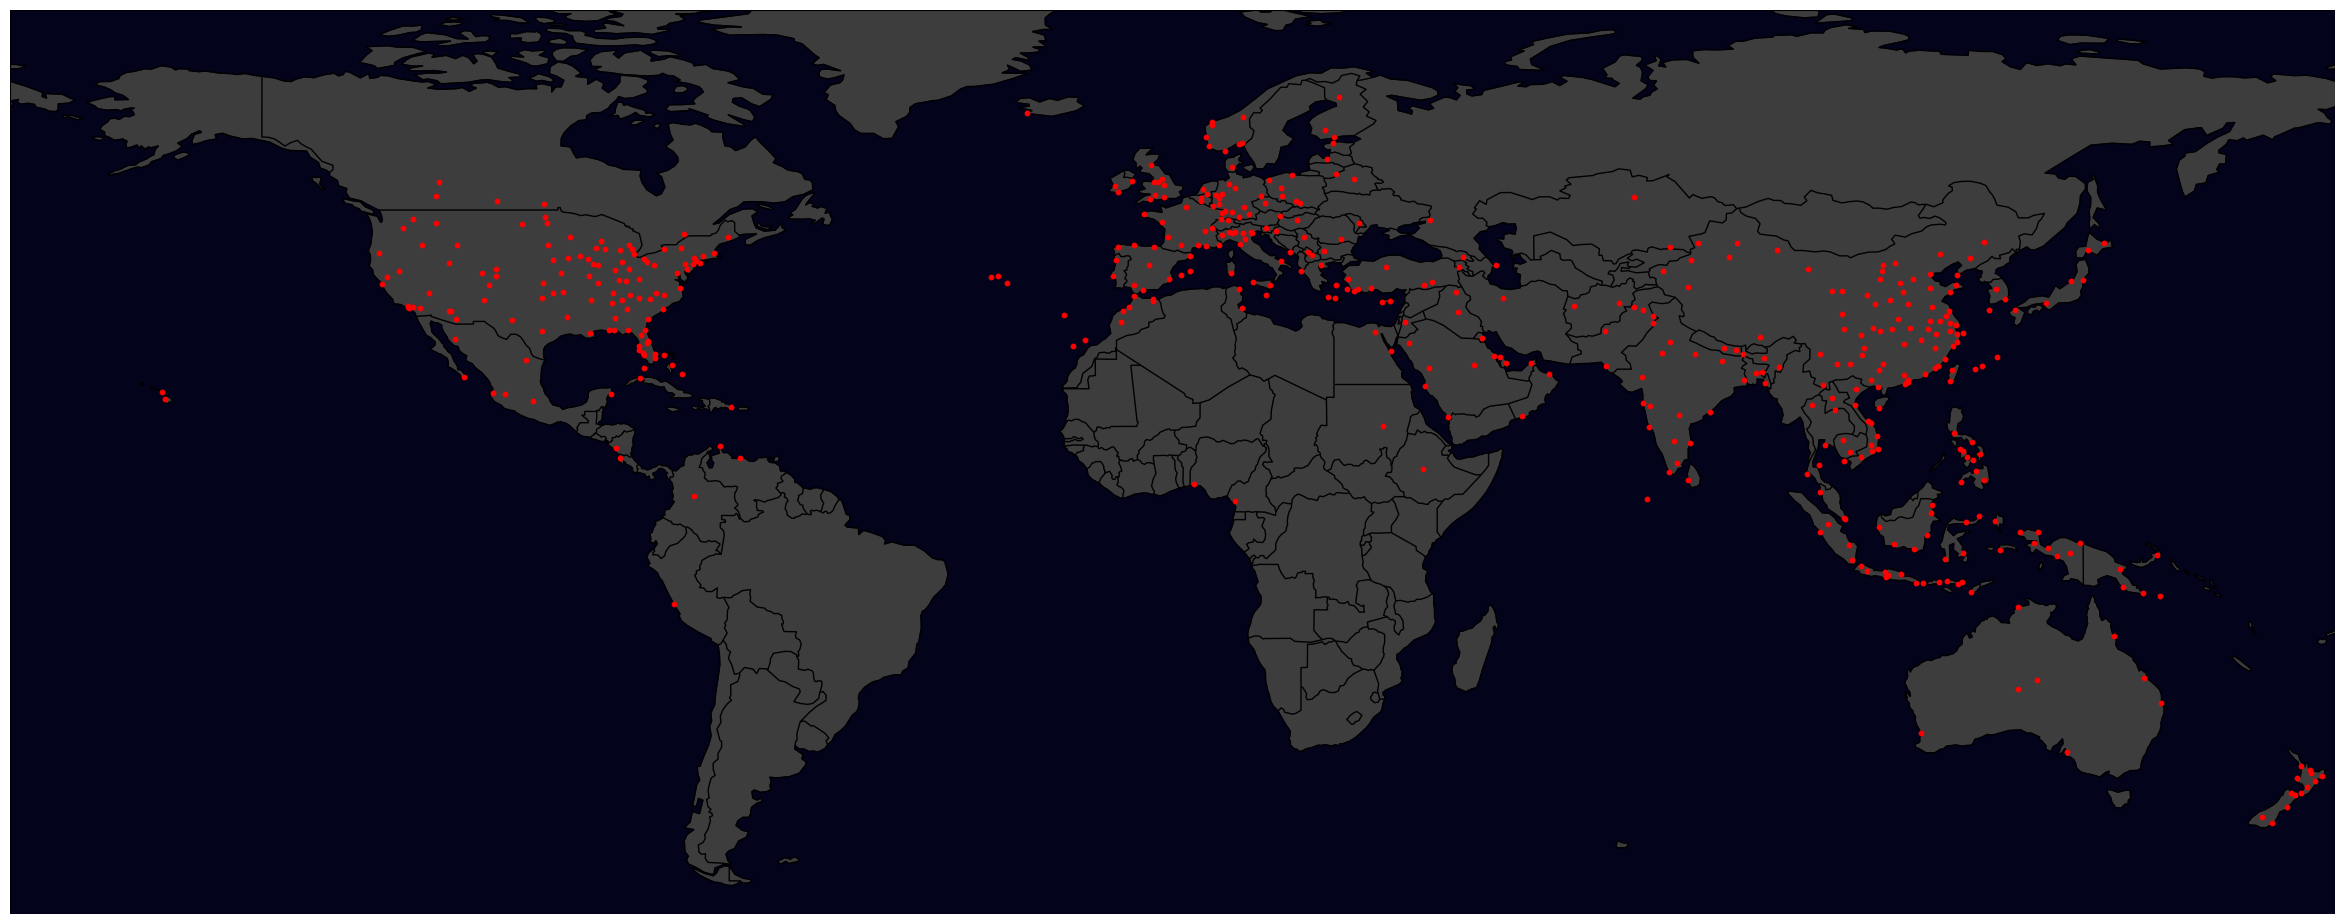

In [13]:
for scenario in ['realistic', 'mild', 'strict']:
    result_cities = get_spread_data(f"../simulation_data/INFECTED_CITIES_{scenario}_0", airport_df)
    graph, xycoords = get_graph(result_cities, airport_df)
    fig = plt.figure(figsize=(30, 15))
    plt.imshow(visualise_spread_for_day(xycoords, 100, 'Nodes', result_cities))
    plt.axis('off')
    plt.show()

  0%|          | 0/1729 [00:00<?, ?it/s]

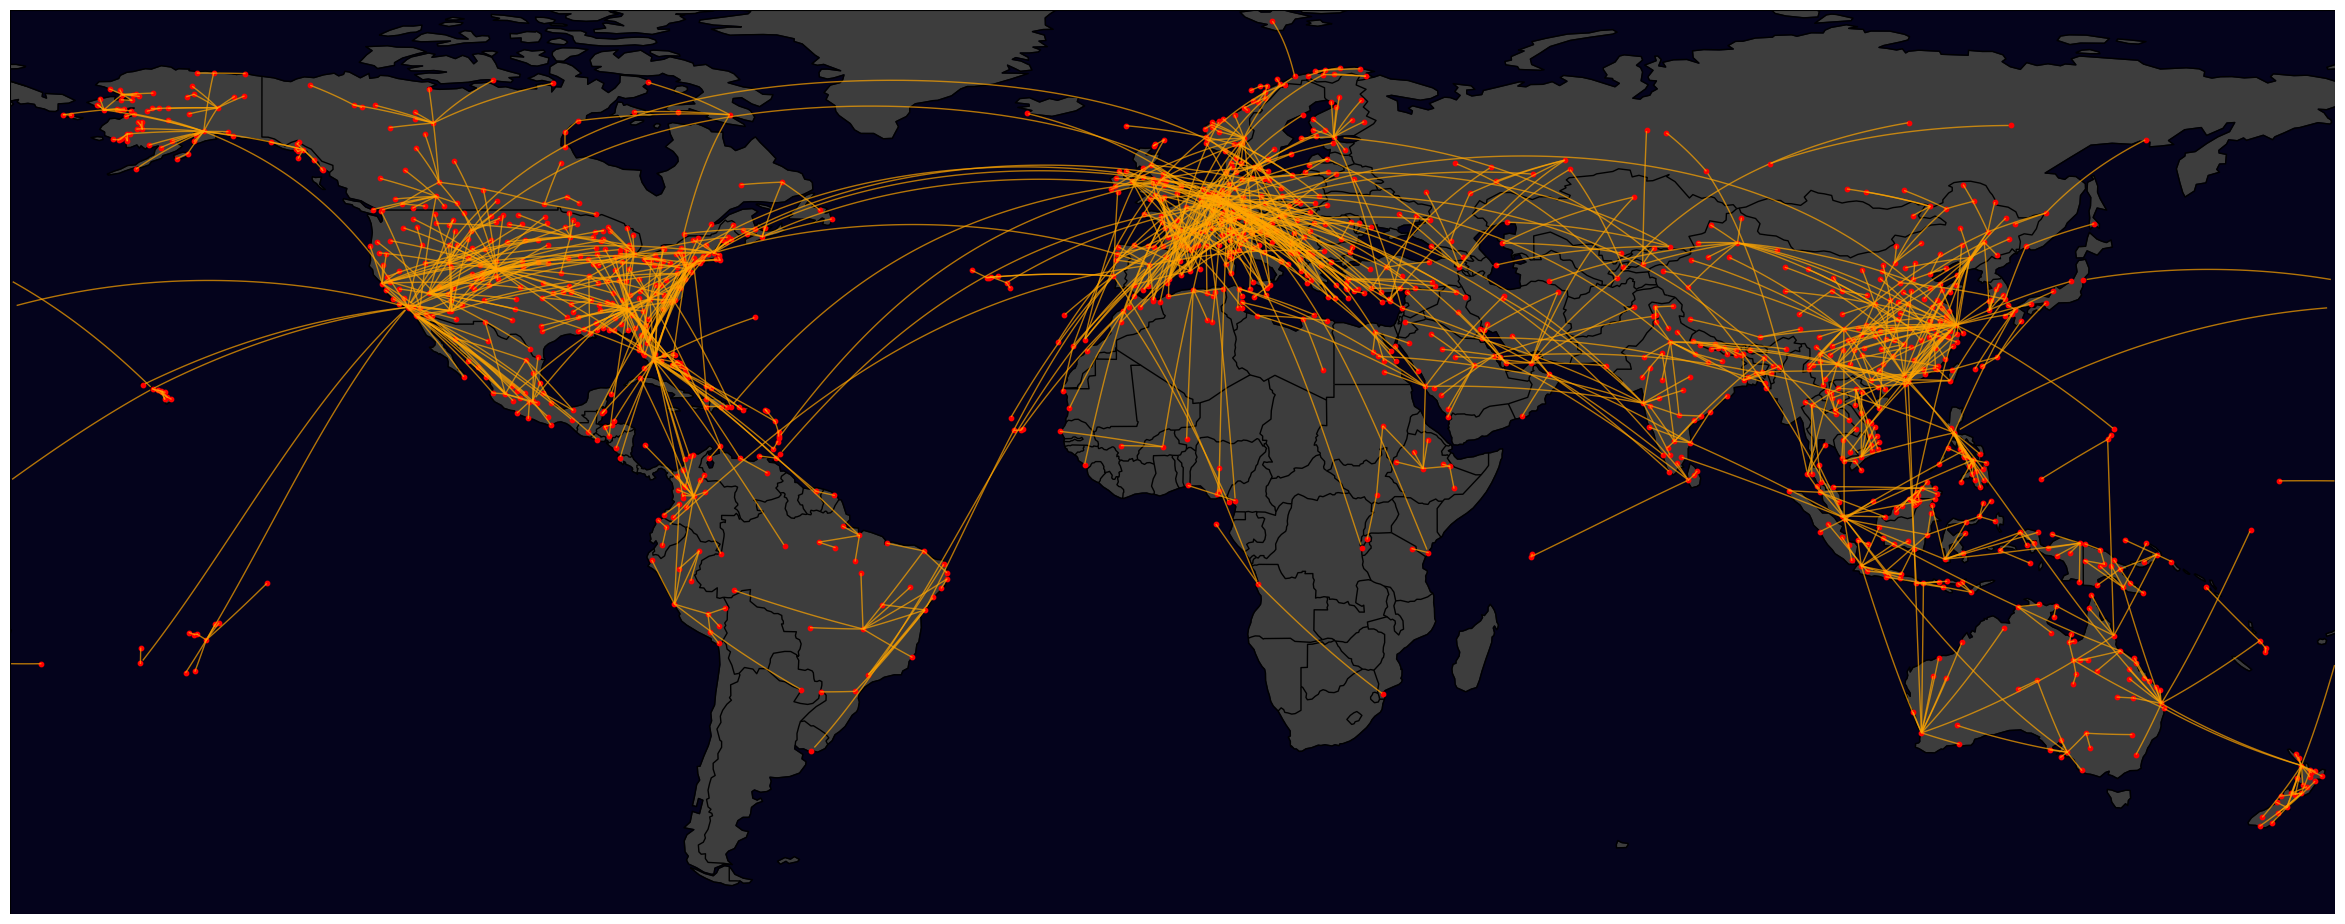

  0%|          | 0/2232 [00:00<?, ?it/s]

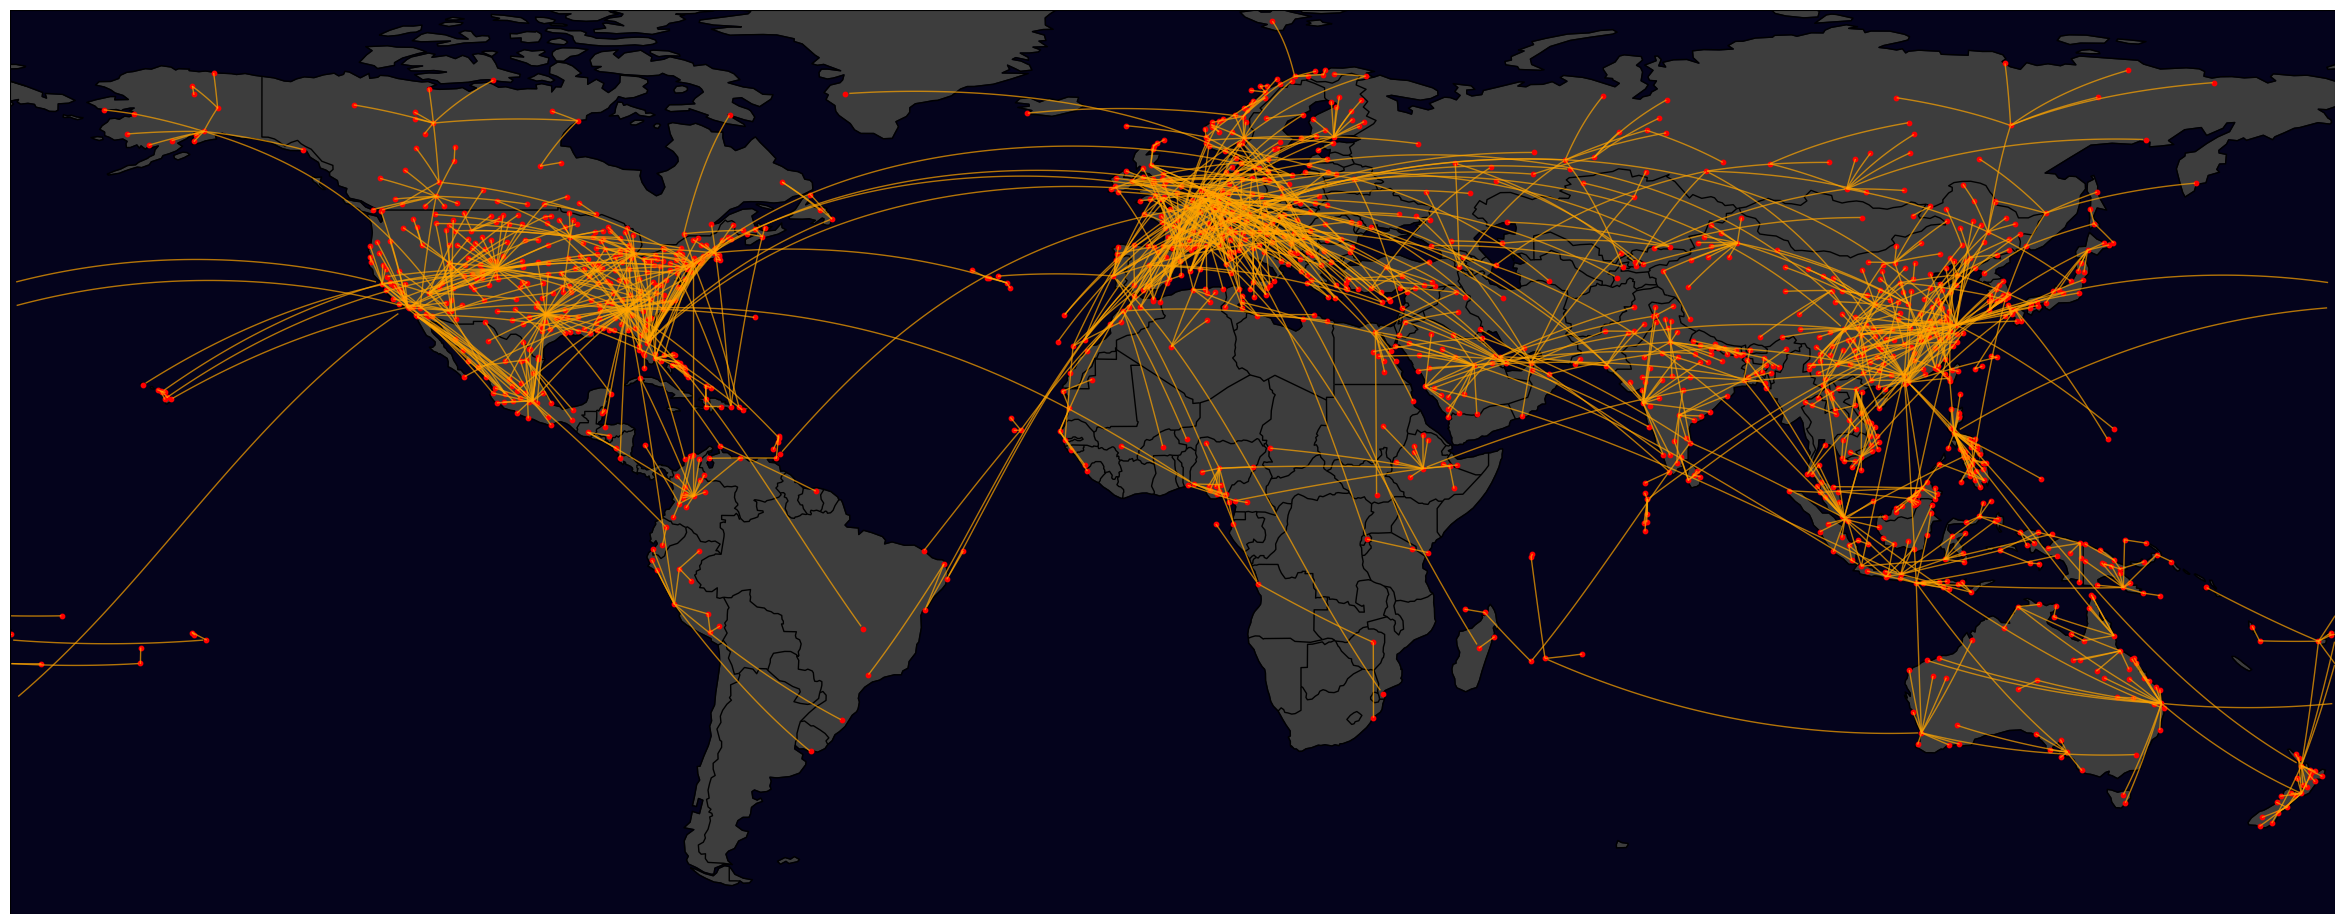

  0%|          | 0/745 [00:00<?, ?it/s]

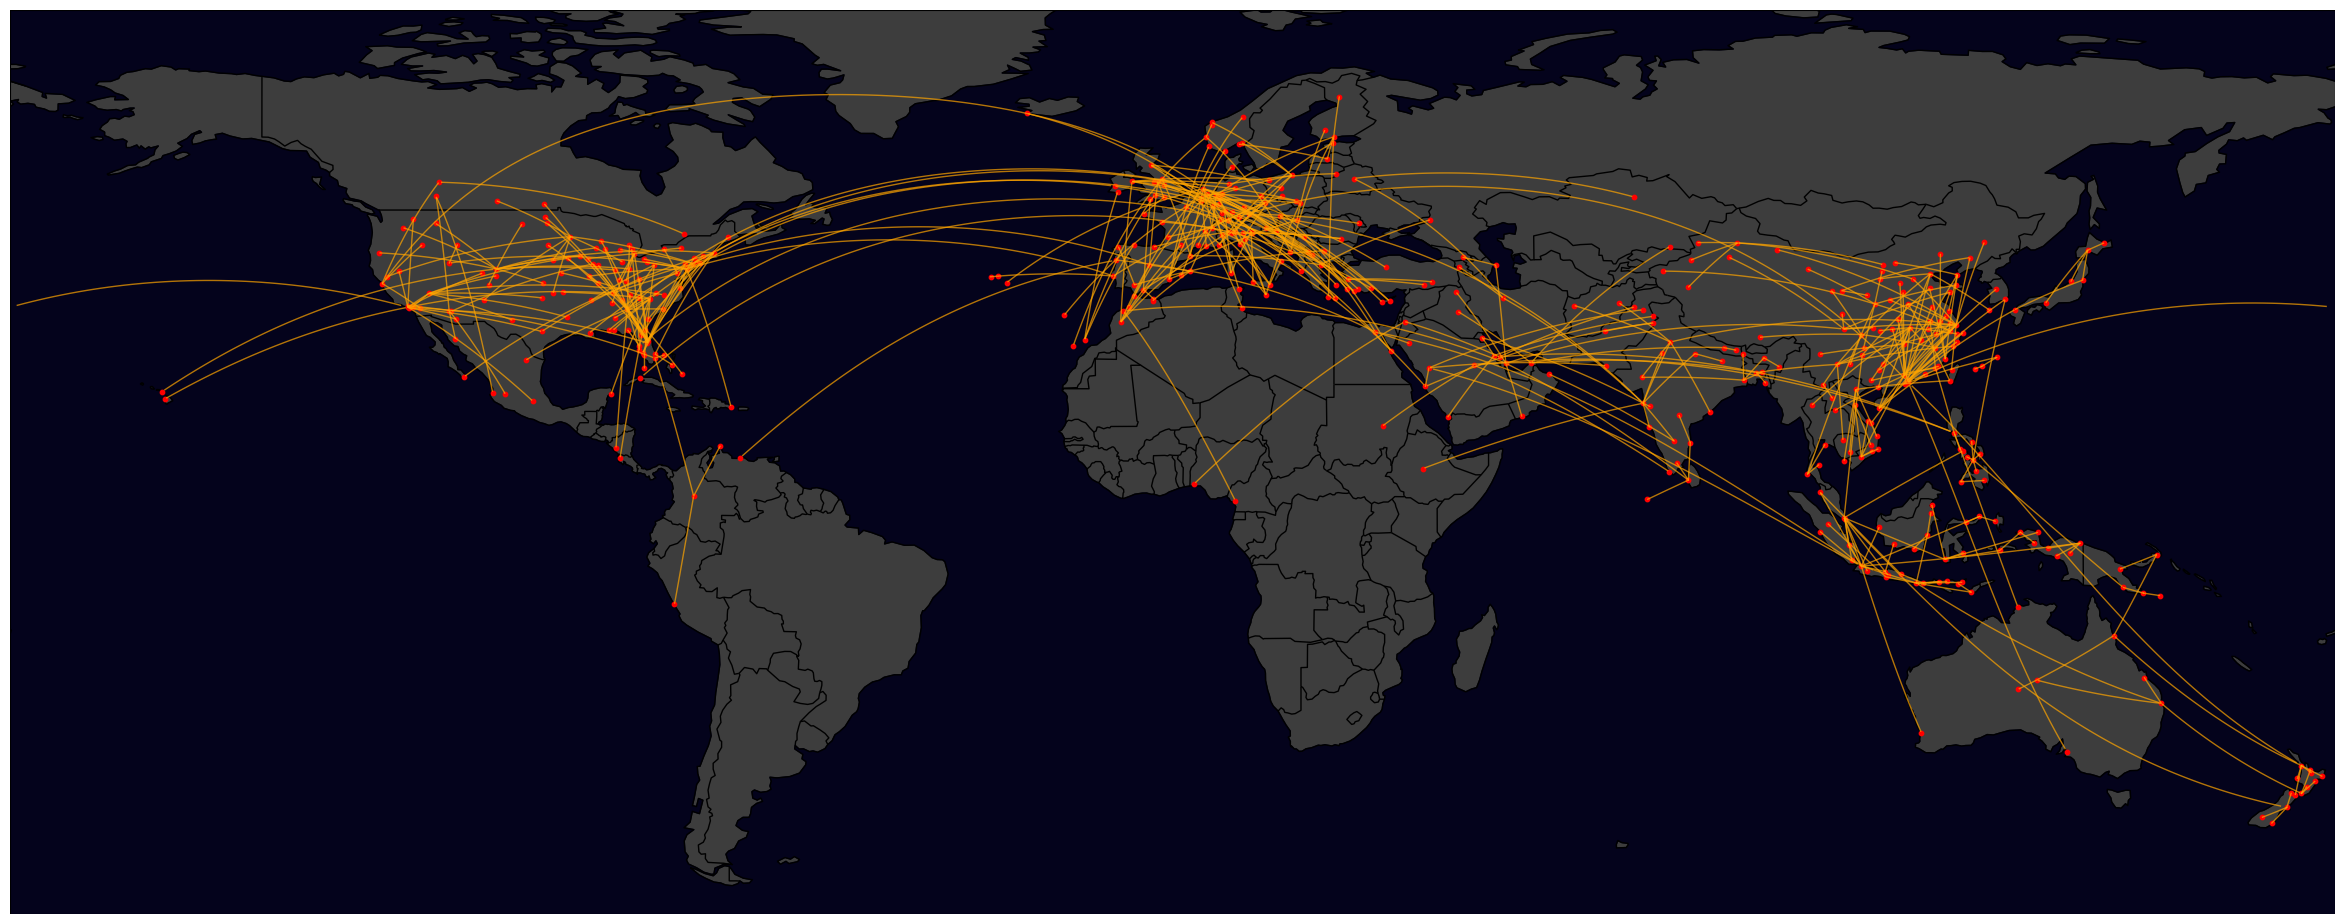

In [14]:
for scenario in ['realistic', 'mild', 'strict']:
    result_cities = get_spread_data(f"../simulation_data/INFECTED_CITIES_{scenario}_0", airport_df)
    graph, xycoords = get_graph(result_cities, airport_df)
    fig = plt.figure(figsize=(30, 15))
    plt.imshow(visualise_spread_for_day(xycoords, 100, 'Paths', result_cities))
    plt.axis('off')
    plt.show()